<a href="https://colab.research.google.com/github/ShirsaM/My-Google-Colab/blob/main/Polynomial_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Polynomial Regression

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab as pl
%matplotlib inline

In [2]:
!wget -O FuelConsumption.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%202/data/FuelConsumptionCo2.csv

--2022-02-08 14:59:56--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%202/data/FuelConsumptionCo2.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72629 (71K) [text/csv]
Saving to: ‘FuelConsumption.csv’

FuelConsumption.csv 100%[===================>]  70.93K  --.-KB/s    in 0.06s   

2022-02-08 14:59:56 (1.15 MB/s) - ‘FuelConsumption.csv’ saved [72629/72629]



<h2 id="understanding_data">Understanding the Data</h2>

### `FuelConsumption.csv`:

We have downloaded a fuel consumption dataset, **`FuelConsumption.csv`**, which contains model-specific fuel consumption ratings and estimated carbon dioxide emissions for new light-duty vehicles for retail sale in Canada. [Dataset source](http://open.canada.ca/data/en/dataset/98f1a129-f628-4ce4-b24d-6f16bf24dd64?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01)

*   **MODELYEAR** e.g. 2014
*   **MAKE** e.g. Acura
*   **MODEL** e.g. ILX
*   **VEHICLE CLASS** e.g. SUV
*   **ENGINE SIZE** e.g. 4.7
*   **CYLINDERS** e.g 6
*   **TRANSMISSION** e.g. A6
*   **FUELTYPE** e.g. z
*   **FUEL CONSUMPTION in CITY(L/100 km)** e.g. 9.9
*   **FUEL CONSUMPTION in HWY (L/100 km)** e.g. 8.9
*   **FUEL CONSUMPTION COMB (L/100 km)** e.g. 9.2
*   **CO2 EMISSIONS (g/km)** e.g. 182   --> low --> 0


In [3]:
df = pd.read_csv("FuelConsumption.csv")

df.head()

,MODELYEAR,MAKE,MODEL,VEHICLECLASS,ENGINESIZE,CYLINDERS,TRANSMISSION,FUELTYPE,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
0,2014,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,2014,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,2014,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,2014,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,2014,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


In [4]:
cdf = df[['ENGINESIZE' , 'CYLINDERS' , 'FUELCONSUMPTION_COMB' , 'CO2EMISSIONS']]

cdf.head(10)

,ENGINESIZE,CYLINDERS,FUELCONSUMPTION_COMB,CO2EMISSIONS
0,2.0,4,8.5,196
1,2.4,4,9.6,221
2,1.5,4,5.9,136
3,3.5,6,11.1,255
4,3.5,6,10.6,244
5,3.5,6,10.0,230
6,3.5,6,10.1,232
7,3.7,6,11.1,255
8,3.7,6,11.6,267
9,2.4,4,9.2,212


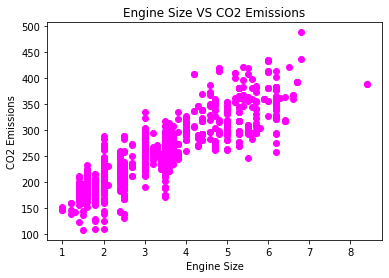

In [5]:
plt.scatter(cdf.ENGINESIZE , cdf.CO2EMISSIONS , color="magenta")
plt.title('Engine Size VS CO2 Emissions')
plt.xlabel('Engine Size')
plt.ylabel('CO2 Emissions')
plt.show()

#### Creating train and test dataset

Train/Test Split involves splitting the dataset into training and testing sets respectively, which are mutually exclusive. After which, you train with the training set and test with the testing set.
This will provide a more accurate evaluation on out-of-sample accuracy because the testing dataset is not part of the dataset that have been used to train the model. Therefore, it gives us a better understanding of how well our model generalizes on new data.

We know the outcome of each data point in the testing dataset, making it great to test with! Since this data has not been used to train the model, the model has no knowledge of the outcome of these data points. So, in essence, it is truly an out-of-sample testing.

Let's split our dataset into train and test sets. Around 80% of the entire dataset will be used for training and 20% for testing. We create a mask to select random rows using the  **np.random.rand()** function:


In [6]:
msk = np.random.rand(len(df)) < 0.8

train = cdf[msk]
test = cdf[~msk]

## Polynomial Regression

Sometimes, the trend of data is not really linear, and looks curvy. In this case we can use Polynomial regression methods. In fact, many different regressions exist that can be used to fit whatever the dataset looks like, such as quadratic, cubic, and so on, and it can go on and on to infinite degrees.

In essence, we can call all of these, polynomial regression, where the relationship between the independent variable x and the dependent variable y is modeled as an nth degree polynomial in x. Lets say you want to have a polynomial regression (let's make 2 degree polynomial):

$$y = b + \theta\_1  x + \theta\_2 x^2$$

Now, the question is: how we can fit our data on this equation while we have only x values, such as **Engine Size**?
Well, we can create a few additional features: 1, $x$, and $x^2$.

**PolynomialFeatures()** function in Scikit-learn library, drives a new feature sets from the original feature set. That is, a matrix will be generated consisting of all polynomial combinations of the features with degree less than or equal to the specified degree. For example, lets say the original feature set has only one feature, *ENGINESIZE*. Now, if we select the degree of the polynomial to be 2, then it generates 3 features, degree=0, degree=1 and degree=2:


In [7]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
train_x = np.asanyarray(train[['ENGINESIZE']])
train_y = np.asanyarray(train[['CO2EMISSIONS']])

test_x = np.asanyarray(test[['ENGINESIZE']])
test_y = np.asanyarray(test[['CO2EMISSIONS']])


poly = PolynomialFeatures(degree=2)
train_x_poly = poly.fit_transform(train_x)
train_x_poly

array([[ 1.  ,  2.4 ,  5.76],
       [ 1.  ,  3.5 , 12.25],
       [ 1.  ,  3.5 , 12.25],
       ...,
       [ 1.  ,  3.2 , 10.24],
       [ 1.  ,  3.  ,  9.  ],
       [ 1.  ,  3.2 , 10.24]])

**fit_transform** takes our x values, and output a list of our data raised from power of 0 to power of 2 (since we set the degree of our polynomial to 2).

The equation and the sample example is displayed below.

$$
\begin{bmatrix}
v\_1\\\\
v\_2\\\\
\vdots\\\\
v_n
\end{bmatrix}\longrightarrow \begin{bmatrix}
\[ 1 & v\_1 & v\_1^2]\\\\
\[ 1 & v\_2 & v\_2^2]\\\\
\vdots & \vdots & \vdots\\\\
\[ 1 & v_n & v_n^2]
\end{bmatrix}
$$

$$
\begin{bmatrix}
2.\\\\
2.4\\\\
1.5\\\\
\vdots
\end{bmatrix} \longrightarrow \begin{bmatrix}
\[ 1 & 2. & 4.]\\\\
\[ 1 & 2.4 & 5.76]\\\\
\[ 1 & 1.5 & 2.25]\\\\
\vdots & \vdots & \vdots\\\\
\end{bmatrix}
$$


It looks like feature sets for multiple linear regression analysis, right? Yes. It Does.
Indeed, Polynomial regression is a special case of linear regression, with the main idea of how do you select your features. Just consider replacing the  $x$ with $x\_1$, $x\_1^2$ with $x\_2$, and so on. Then the 2nd degree equation would be turn into:

$$y = b + \theta\_1  x\_1 + \theta\_2 x\_2$$

Now, we can deal with it as a 'linear regression' problem. Therefore, this polynomial regression is considered to be a special case of traditional multiple linear regression. So, you can use the same mechanism as linear regression to solve such problems.

so we can use **LinearRegression()** function to solve it:


In [8]:
clf = linear_model.LinearRegression()
train_y_ = clf.fit(train_x_poly, train_y)
# The coefficients
print ('Coefficients: ', clf.coef_)
print ('Intercept: ',clf.intercept_)

Coefficients:  [[ 0.         49.7791334  -1.46316723]]
Intercept:  [109.81612735]


As mentioned before, **Coefficient** and **Intercept** , are the parameters of the fit curvy line.
Given that it is a typical multiple linear regression, with 3 parameters, and knowing that the parameters are the intercept and coefficients of hyperplane, sklearn has estimated them from our new set of feature sets. Lets plot it:


Text(0, 0.5, 'Emission')

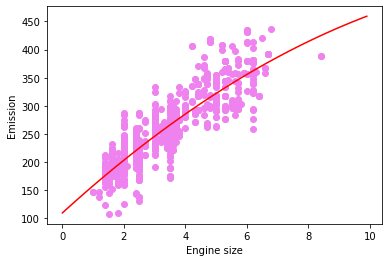

In [24]:
plt.scatter(train.ENGINESIZE, train.CO2EMISSIONS,  color='violet')
XX = np.arange(0.0, 10.0, 0.1)   
# numpy.arange([start, ]stop, [step, ], dtype=None) -> numpy.ndarray

yy = clf.intercept_[0]+ clf.coef_[0][1]*XX+ clf.coef_[0][2]*np.power(XX, 2)
plt.plot(XX, yy, '-r' )
plt.xlabel("Engine size")
plt.ylabel("Emission")

In [10]:
from sklearn.metrics import r2_score

test_x_poly = poly.transform(test_x)
test_y_ = clf.predict(test_x_poly)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_ - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_ - test_y) ** 2))
print("R2-score: %.2f" % r2_score(test_y,test_y_ ) )

Mean absolute error: 24.51
Residual sum of squares (MSE): 946.90
R2-score: 0.77


<h2 id="practice">Practice</h2>
Try to use a polynomial regression with the dataset but this time with degree three (cubic). Does it result in better accuracy?


In [17]:
polyn = PolynomialFeatures(degree=3)

train_x_polyn = polyn.fit_transform(train_x)
train_x_polyn

array([[ 1.   ,  2.4  ,  5.76 , 13.824],
       [ 1.   ,  3.5  , 12.25 , 42.875],
       [ 1.   ,  3.5  , 12.25 , 42.875],
       ...,
       [ 1.   ,  3.2  , 10.24 , 32.768],
       [ 1.   ,  3.   ,  9.   , 27.   ],
       [ 1.   ,  3.2  , 10.24 , 32.768]])

In [18]:
regr = linear_model.LinearRegression()
train_y__ = regr.fit(train_x_polyn, train_y)

print("Coefficients:- " , regr.coef_)
print("Intercept:- " , regr.intercept_)

Coefficients:-  [[ 0.         21.02768151  6.42053175 -0.64992294]]
Intercept:-  [140.45478645]


Text(0, 0.5, 'CO2 Emissions')

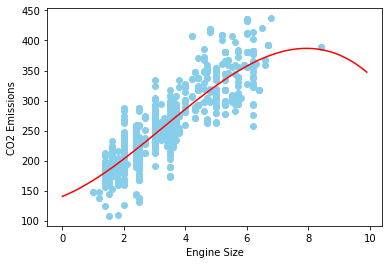

In [22]:
XX1 = np.arange(0.0 , 10.0 , 0.1)
YY1 = regr.intercept_[0] + regr.coef_[0][1] * XX1 + regr.coef_[0][2] * np.power(XX1,2) + regr.coef_[0][3] * np.power(XX1,3)

plt.scatter(train.ENGINESIZE , train.CO2EMISSIONS , color='skyblue')
plt.plot(XX1 , YY1 , '-r')
plt.xlabel("Engine Size")
plt.ylabel("CO2 Emissions")

In [23]:
test_x_polyn = polyn.transform(test_x)
test_y__ = regr.predict(test_x_polyn)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y__ - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y__ - test_y) ** 2))
print("R2-score: %.2f" % r2_score(test_y,test_y__ ) )

Mean absolute error: 24.71
Residual sum of squares (MSE): 961.12
R2-score: 0.77
